In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import random

# ****Data Loading

In [5]:
# go to input dir of stocks and use one txt file for processing

os.chdir('/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks')

In [6]:
files=os.listdir()
len(files)

7195

# ****Sampling

In [7]:
data=random.sample([x for x in files if x.endswith('txt') and x.startswith('cms')and os.path.getsize(x)>400000],1)

In [8]:
data

['cms.us.txt']

In [9]:
for i in data:
    df = pd.read_csv(i)


In [10]:
#set date column as index and drop from dataframe
df=df.set_index(df['Date'])
df.drop('Date',axis=1,inplace=True)
df.head()

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
1984-12-31,2.1121,2.2303,2.1121,2.2303,1003711,0
1985-01-02,2.2303,2.2303,2.1750,2.2303,126257,0
1985-01-03,2.2303,2.2303,2.1750,2.2303,62047,0
1985-01-04,2.2303,2.2303,2.1750,2.2303,76517,0
1985-01-07,2.1750,2.2303,2.1750,2.1750,96819,0


In [11]:
df.shape

(8280, 6)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8280 entries, 1984-12-31 to 2017-11-10
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Open     8280 non-null   float64
 1   High     8280 non-null   float64
 2   Low      8280 non-null   float64
 3   Close    8280 non-null   float64
 4   Volume   8280 non-null   int64  
 5   OpenInt  8280 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 452.8+ KB


In [12]:
window_size=30
train_data=df.iloc[:(7200+window_size), 0:1]
train_data.shape

(7230, 1)

# ****One-Hot Encoding

In [13]:
#preprocess data using Minmax sclaer
scaler=preprocessing.MinMaxScaler()
train_data_transform=scaler.fit_transform(np.array(train_data))

# ****Training

In [14]:
x_train,y_train=[],[]
for i in range(len(train_data_transform)-window_size):
    x_train.append(train_data_transform[i:i+window_size])
    y_train.append(train_data_transform[i+window_size])
    

In [15]:
x_train=np.array(x_train)

In [16]:
y_train=np.array(y_train)
y_train.shape

(7200, 1)

# ****Modelling

In [17]:
model=tf.keras.models.Sequential(
    [tf.keras.layers.LSTM(100,return_sequences=True,input_shape=(x_train.shape[1], x_train.shape[2])),
     tf.keras.layers.Dropout(0.3),
     tf.keras.layers.LSTM(50,return_sequences=True),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.LSTM(50),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.Dense(1)
    ])


model.summary()
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 30, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 50)            30200     
                                                                 
 dropout_1 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [18]:
model.fit(x_train, y_train, epochs=13, batch_size=40)

Epoch 1/13
180/180 [==============================] - 18s 60ms/step - loss: 0.0066 - accuracy: 1.3889e-04
Epoch 2/13
180/180 [==============================] - 10s 56ms/step - loss: 0.0021 - accuracy: 1.3889e-04
Epoch 3/13
180/180 [==============================] - 10s 57ms/step - loss: 0.0018 - accuracy: 1.3889e-04
Epoch 4/13
180/180 [==============================] - 10s 54ms/step - loss: 0.0016 - accuracy: 1.3889e-04
Epoch 5/13
180/180 [==============================] - 11s 61ms/step - loss: 0.0014 - accuracy: 1.3889e-04
Epoch 6/13
180/180 [==============================] - 11s 62ms/step - loss: 0.0014 - accuracy: 1.3889e-04
Epoch 7/13
180/180 [==============================] - 10s 56ms/step - loss: 0.0013 - accuracy: 1.3889e-04
Epoch 8/13
180/180 [==============================] - 10s 56ms/step - loss: 0.0012 - accuracy: 1.3889e-04
Epoch 9/13
180/180 [==============================] - 10s 57ms/step - loss: 0.0010 - accuracy: 1.3889e-04
Epoch 10/13
180/180 [=========================

In [19]:
train_data = df.iloc[ :int(7200)]
test_data = df.iloc[int(7200): ]
        
        # combining the dataset and taking final test_data shape.
data = pd.concat((train_data['Open'], test_data['Open']), axis=0)
        # len(train_data) - window_size == 7242 - 10 == 7432.
        # Hence, test_set starts from 7432 to take 7243 row as output.
test_input_shape = data[len(train_data) - window_size: ].values
test_input_shape = test_input_shape.reshape(-1,1)
test_input_shape = scaler.transform(test_input_shape) #only transforming the test data.
        
X_test = []
        
for i in range(window_size, len(test_data)+window_size): 
    X_test.append(test_input_shape[i-window_size:i, 0])
            
X_test = np.array(X_test)

In [20]:
X_test.shape

(1080, 30)

In [21]:
 #to make values compatible with lstm
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [22]:
prediction = model.predict(X_test)

prediction_inverse = scaler.inverse_transform(prediction)

34/34 [==============================] - 3s 23ms/step


In [23]:
prediction_inverse.shape

(1080, 1)

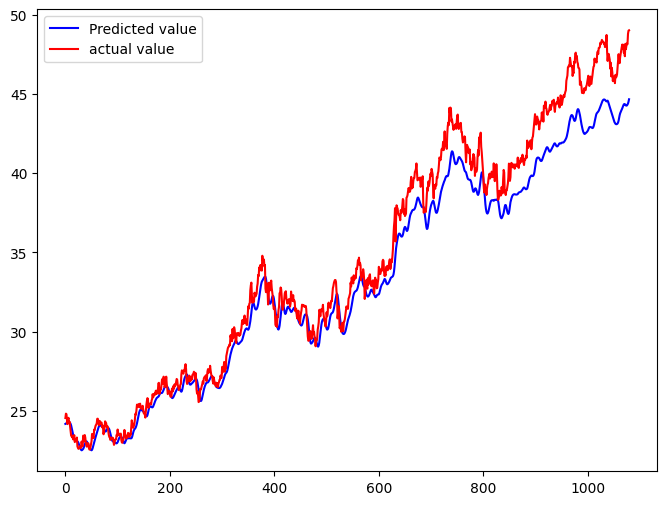

In [24]:

y_test = df.iloc[int(7200): ,0:1].values
plt.figure(figsize=(8,6))
plt.plot(prediction_inverse, color='blue', label='Predicted value')
plt.plot(y_test, color ='red', label='actual value')
plt.legend()
plt.show()



In [25]:
print('Mean Absolute Error: ', mean_absolute_error(y_test, prediction_inverse))
print('Mean Squared Error: ', mean_squared_error(y_test, prediction_inverse))

Mean Absolute Error:  1.332214810463234
Mean Squared Error:  2.946921348304514
